## Feature Learner ( SIMCLR_S ) Comparison Across Different HAR Datasets

The file model_wrappers.py has a collection of feature extractors that all share one interface.

The shared interface is:
    learner = Learner_Class(train_X, train_y)
    learner.fit(train_X, train_y, validation_X, validation_y)
    features = learner.get_fearures(any_X)

The X inputs should be numpy arrays with the shape set_length x channels x number_of_samples

The y inputs should be 1d numpy arrays (not one-hot)

The features will always be returned as a numpy array with shape length_of_X x 64, or length_of_X x 18 for the engineered features.


Did not include leotta and Mobiact because those data loaders were written to be executed from google colab and have prewritten file paths.

Tried including shl data set but it way too large

Both HUAWEI and E4 were included my importing the NP-arrays stored in files

In [1]:
#Make sure local file structure exists
import os

if not os.path.exists('temp'):
    os.mkdir('temp')

In [2]:
import numpy as np
import sys
import umap.umap_ as umap
import matplotlib.pyplot as plt
from model_wrappers import SimCLR_C, Engineered_Features
from load_data_time_series.HAR.UniMiB_SHAR.unimib_shar_adl_load_dataset import unimib_load_dataset
#from load_data_time_series.ADL.Leotta_2021.leotta_2021_load_dataset import leotta_2021_load_dataset
#from load_data_time_series.HAR.e4_wristband_Nov2019.e4_load_dataset import e4_load_dataset
from load_data_time_series.HAR.UCI_HAR.uci_har_load_dataset import uci_har_load_dataset
#from load_data_time_series.HAR.shl_load_dataset import shl_load_dataset
home_dir = os.getcwd()

In [4]:
def channel_swap(X : np.ndarray) -> np.ndarray:
    """
    Return channels first array from channels last or vice versa
"""
    assert X.ndim == 3, "Data must be 3-dimensional to channel swap"
    # return np.reshape(X, (X.shape[0], X.shape[2], X.shape[1]))
    return np.moveaxis(X, 2, 1)

def channel_swap_gen(X_train : np.ndarray, X_val: np.ndarray, X_test : np.ndarray, name):
    X_train = channel_swap(X_train)
    X_test = channel_swap(X_test)
    X_val = channel_swap(X_val)
    print("\n"+name)
    print("X_train Shape: ",X_train.shape)
    print("X_val Shape: ",X_val.shape)
    print("X_test Shape: ",X_test.shape,"\n")
    return X_train, X_val, X_test

def make_yarr_1d(y_train : np.ndarray, y_val : np.ndarray, y_test : np.ndarray, name):
    y_train = np.array(np.argmax(y_train, axis=-1))
    y_val = np.array(np.argmax(y_val, axis=-1))
    y_test = np.array(np.argmax(y_test, axis=-1))

    print("\n"+name)
    print("y_train Shape: ",y_train.shape)
    print("y_val Shape: ",y_val.shape)
    print("y_test Shape: ",y_test.shape,"\n")    
    return y_train, y_val, y_test

#return e4 np arrays but could return any of the arrays stored in the data folder
def load_data(folder):
    os.chdir(os.path.join(home_dir,'data',folder))
    X_train_e4 = np.load('x_train'+'_'+folder+'.npy')
    y_train_e4 = np.load('y_train'+'_'+folder+'.npy')
    X_val_e4 = np.load('x_val'+'_'+folder+'.npy')
    y_val_e4 = np.load('y_val'+'_'+folder+'.npy')
    X_test_e4 = np.load('x_test'+'_'+folder+'.npy')
    y_test_e4 = np.load('y_test'+'_'+folder+'.npy')
    os.chdir(home_dir)
    return X_train_e4, y_train_e4, X_val_e4, y_val_e4, X_test_e4, y_test_e4

def load_huawei():
    os.chdir(os.path.join(home_dir,'data', 'Sussex_Huawei_DS'))
    x_train = np.load('x_train.npy')
    y_train = np.load('y_train.npy')
    x_test = np.load('x_test.npy')
    y_test = np.load('y_test.npy')
    os.chdir(home_dir)
    
    return x_train, y_train, x_test, y_test

In [7]:
#Import datasets
#UNIMIB

X_train_uni, y_train_uni, X_val_uni, y_val_uni, X_test_uni, y_test_uni = unimib_load_dataset(
                                                                        incl_xyz_accel=True,
                                                                        incl_rms_accel=False,
                                                                        incl_val_group=True)

X_train_uci, y_train_uci, X_val_uci, y_val_uci, X_test_uci, y_test_uci = uci_har_load_dataset(
                                                                        incl_val_group=True,
                                                                        incl_xyz_accel=True)
X_train_e4, y_train_e4, X_val_e4, y_val_e4, X_test_e4, y_test_e4 = load_data('e4')
#X_train_leo, y_train_leo, X_val_leo, y_val_leo, X_test_leo, y_test_leo = load_data('leotta')

#im going to include huawei just to see, I will use the testing np arrays as a proxy for validation
X_train_hua, y_train_hua, X_test_hua, y_test_hua = load_huawei()

#Put X arrays into channels-first format
X_train_uni, X_val_uni, X_test_uni = channel_swap_gen(X_train_uni, X_val_uni, X_test_uni,"unimib")
X_train_uci, X_val_uci, X_test_uci = channel_swap_gen(X_train_uci, X_val_uci, X_test_uci,"uci")
X_train_e4, X_val_e4, X_test_e4 = channel_swap_gen(X_train_e4, X_val_e4, X_test_e4,"e4")
X_train_hua = channel_swap(X_train_hua)
X_test_hua = channel_swap(X_test_hua)


#Make y arrays 1d
y_train_uni, y_val_uni, y_test_uni = make_yarr_1d(y_train_uni, y_val_uni, y_test_uni,"unimib")
y_train_uci, y_val_uci, y_test_uci = make_yarr_1d(y_train_uci, y_val_uci, y_test_uci,"uci")
y_train_e4, y_val_e4, y_test_e4 = make_yarr_1d(y_train_e4, y_val_e4, y_test_e4,"e4")
y_train_hua = np.array(np.argmax(y_train_hua, axis=-1))
y_test_hua = np.array(np.argmax(y_test_hua, axis=-1))


Raw data     shape        object type              data type
-----------  -----------  -----------------------  -----------
adl_data:    (7579, 453)  <class 'numpy.ndarray'>  float64
adl_labels:  (7579, 3)    <class 'numpy.ndarray'>  uint8
adl_names:   (9, 1)       <class 'numpy.ndarray'>  object
Reshaped data    shape           object type              data type
---------------  --------------  -----------------------  -----------
adl_data:        (7579, 151, 3)  <class 'numpy.ndarray'>  float64
adl_labels:      (7579, 3)       <class 'numpy.ndarray'>  uint8
adl_names:       (9, 1)          <class 'numpy.ndarray'>  object
x/y_train shape  (4601, 151, 3) (4601,)
x/y_validation shape  (1454, 151, 3) (1454,)
x/y_test shape   (1524, 151, 3) (1524,)
After one-hot encoding
x/y_train shape  (4601, 151, 3) (4601, 9)
x/y_validation shape  (1454, 151, 3) (1454, 9)
x/y_test shape   (1524, 151, 3) (1524, 9)
.\UCI_HAR_Dataset.zip found, skipping download
.\UCI HAR Dataset directory found, skipping

In [8]:
#Summon two feature learners for all data sets
#UNIMIB
engineered_extractor_uni = Engineered_Features(X_train_uni, y_train_uni)
simclr_extractor_uni = SimCLR_C(X_train_uni, y_train_uni)

#UCI
engineered_extractor_uci = Engineered_Features(X_train_uci, y_train_uci)
simclr_extractor_uci = SimCLR_C(X_train_uci, y_train_uci)

#E4
engineered_extractor_e4 = Engineered_Features(X_train_e4, y_train_e4)
simclr_extractor_e4 = SimCLR_C(X_train_e4, y_train_e4)

#HUAWEI
engineered_extractor_hua = Engineered_Features(X_train_hua, y_train_hua)
simclr_extractor_hua = SimCLR_C(X_train_hua, y_train_hua)

c:\Users\lynnt\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
#Fit both extractors
#UNIMIB
engineered_extractor_uni.fit(X_train_uni, y_train_uni, X_val_uni, y_val_uni)
simclr_extractor_uni.fit(X_train_uni, y_train_uni, X_val_uni, y_val_uni)

#gather features for unimib
features_1_train_uni = engineered_extractor_uni.get_features(X_train_uni)
features_1_test_uni = engineered_extractor_uni.get_features(X_test_uni)

features_2_train_uni = simclr_extractor_uni.get_features(X_train_uni)
features_2_test_uni = simclr_extractor_uni.get_features(X_test_uni)




Epoch : 0
Saving model at 0 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru0.pt
Train Loss     : 4.8190
Val Loss     : 4.3732
Clusterability     : 0.2946

Epoch : 1
Saving model at 1 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru1.pt
Train Loss     : 4.2424
Val Loss     : 4.2162
Clusterability     : 0.3189

Epoch : 2
Saving model at 2 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru2.pt
Train Loss     : 3.7194
Val Loss     : 4.2305
Clusterability     : 0.4168

Epoch : 3
Saving model at 3 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_

Feature extraction for set with shape:  (4601, 3, 151)
Flattening
Feature extraction for set with shape:  (1524, 3, 151)
Flattening


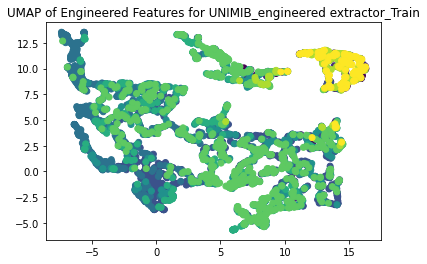

<Figure size 432x288 with 0 Axes>

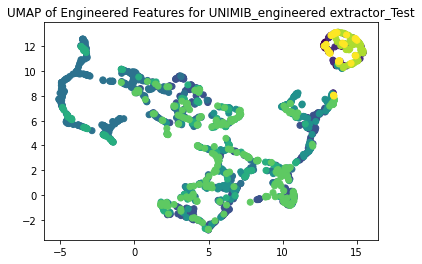

<Figure size 432x288 with 0 Axes>

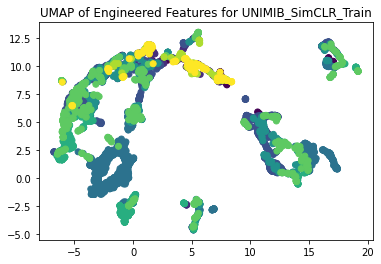

<Figure size 432x288 with 0 Axes>

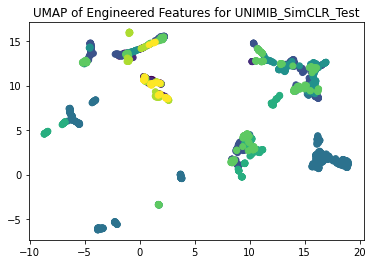

<Figure size 432x288 with 0 Axes>

In [26]:
#function for producing and saving umap visualizations
def produce_umap(features, y, n_c, name):
    reducer = umap.UMAP(n_neighbors = 15, n_components =n_c)
    embedding = reducer.fit_transform(features)
    plt.figure()
    plt.scatter(embedding[:,0], embedding[:,1], c=y)
    plt.title("UMAP of Engineered Features for "+ name)
    plt.show()
    plt.savefig(name+".png")

produce_umap(features_1_train_uni, y_train_uni, 2, "UNIMIB_engineered extractor_Train")
produce_umap(features_1_test_uni, y_test_uni, 2, "UNIMIB_engineered extractor_Test")
produce_umap(features_2_train_uni, y_train_uni, 2, "UNIMIB_SimCLR_Train")
produce_umap(features_2_test_uni, y_test_uni, 2, "UNIMIB_SimCLR_Test")

In [27]:
#UCI
simclr_extractor_uci.fit(X_train_uci, y_train_uci, X_val_uci, y_val_uci)
engineered_extractor_uci.fit(X_train_uci, y_train_uci, X_val_uci, y_val_uci)

#UCI
features_1_train_uci = engineered_extractor_uci.get_features(X_train_uci)
features_1_test_uci = engineered_extractor_uci.get_features(X_test_uci)

features_2_train_uci = simclr_extractor_uci.get_features(X_train_uci)
features_2_test_uci = simclr_extractor_uci.get_features(X_test_uci)


Epoch : 0
Saving model at 0 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru0.pt
Train Loss     : 2.8339
Val Loss     : 8.1350
Clusterability     : 0.2347

Epoch : 1
Saving model at 1 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru1.pt
Train Loss     : 2.8044
Val Loss     : 8.0743
Clusterability     : 0.2161

Epoch : 2
Saving model at 2 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru2.pt
Train Loss     : 2.8140
Val Loss     : 8.1490
Clusterability     : 0.2372

Epoch : 3
Saving model at 3 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_

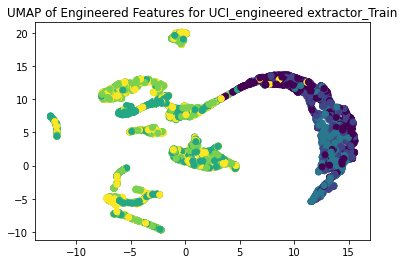

<Figure size 432x288 with 0 Axes>

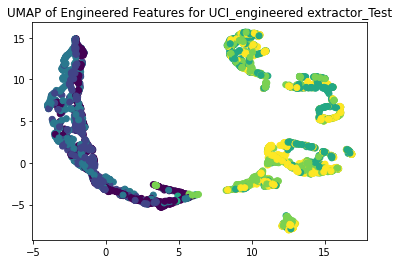

<Figure size 432x288 with 0 Axes>

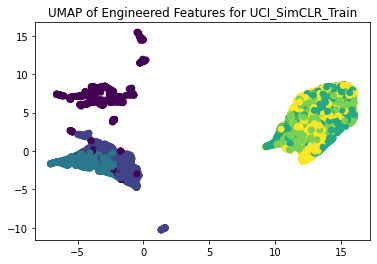

<Figure size 432x288 with 0 Axes>

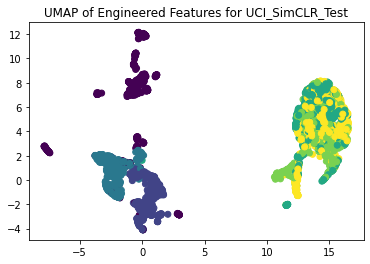

<Figure size 432x288 with 0 Axes>

In [28]:
#Performance on clustering data for UCI may be inflated for training data
#because the validation data for training the model "backbone" was not 
#properly split by subject.

produce_umap(features_1_train_uci, y_train_uci, 2, "UCI_engineered extractor_Train")
produce_umap(features_1_test_uci, y_test_uci, 2, "UCI_engineered extractor_Test")
produce_umap(features_2_train_uci, y_train_uci, 2, "UCI_SimCLR_Train")
produce_umap(features_2_test_uci, y_test_uci, 2, "UCI_SimCLR_Test")

In [29]:
#E4
simclr_extractor_e4.fit(X_train_e4, y_train_e4, X_val_e4, y_val_e4)
engineered_extractor_e4.fit(X_train_e4, y_train_e4, X_val_e4, y_val_e4)

#E4
features_1_train_e4 = engineered_extractor_e4.get_features(X_train_e4)
features_1_test_e4 = engineered_extractor_e4.get_features(X_test_e4)

features_2_train_e4 = simclr_extractor_e4.get_features(X_train_e4)
features_2_test_e4 = simclr_extractor_e4.get_features(X_test_e4)


Epoch : 0
Saving model at 0 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru0.pt
Train Loss     : 5.0256
Val Loss     : 11.5537
Clusterability     : 0.4192

Epoch : 1
Saving model at 1 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru1.pt
Train Loss     : 4.6088
Val Loss     : 11.2385
Clusterability     : 0.4983

Epoch : 2
Saving model at 2 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru2.pt
Train Loss     : 4.3712
Val Loss     : 12.1972
Clusterability     : 0.4742

Epoch : 3
Saving model at 3 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.9

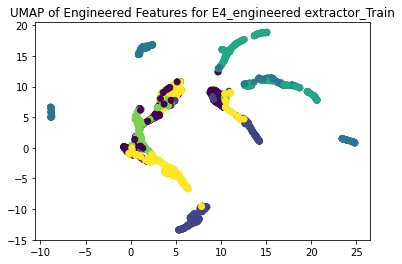

<Figure size 432x288 with 0 Axes>

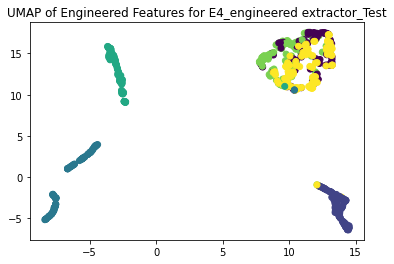

<Figure size 432x288 with 0 Axes>

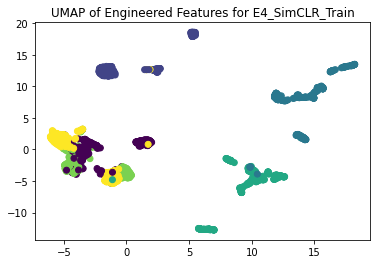

<Figure size 432x288 with 0 Axes>

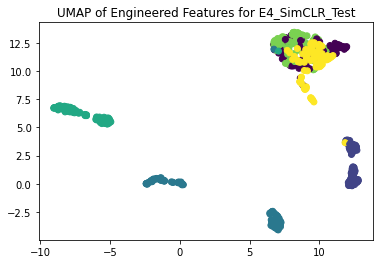

<Figure size 432x288 with 0 Axes>

In [30]:
produce_umap(features_1_train_e4, y_train_e4, 2, "E4_engineered extractor_Train")
produce_umap(features_1_test_e4, y_test_e4, 2, "E4_engineered extractor_Test")
produce_umap(features_2_train_e4, y_train_e4, 2, "E4_SimCLR_Train")
produce_umap(features_2_test_e4, y_test_e4, 2, "E4_SimCLR_Test")

In [32]:
#HUAWEI
#Using testing data in place of validation
simclr_extractor_hua.fit(X_train_hua, y_train_hua, X_test_hua, y_test_hua)
engineered_extractor_hua.fit(X_train_hua, y_train_hua, X_test_hua, y_test_hua)

features_1_train_hua = engineered_extractor_hua.get_features(X_train_hua)
features_1_test_hua = engineered_extractor_hua.get_features(X_test_hua)

features_2_train_hua = simclr_extractor_hua.get_features(X_train_hua)
features_2_test_hua = simclr_extractor_hua.get_features(X_test_hua)


Epoch : 0
Saving model at 0 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru0.pt
Train Loss     : 3.1657
Val Loss     : 3.5064
Clusterability     : 0.6008

Epoch : 1
Saving model at 1 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru1.pt
Train Loss     : 2.0213
Val Loss     : 2.8509
Clusterability     : 0.6140

Epoch : 2
Saving model at 2 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_criterion_NTXent_lambda1_1.0_lambda2_1.0_tempunit_gru2.pt
Train Loss     : 1.4178
Val Loss     : 2.5812
Clusterability     : 0.5921

Epoch : 3
Saving model at 3 epoch to results/pretrain_try_scheduler_simclr_pretrain__eps120_lr0.003_bs100_aug1noise_aug2negate_dim-pdim96-96_EMA0.996_

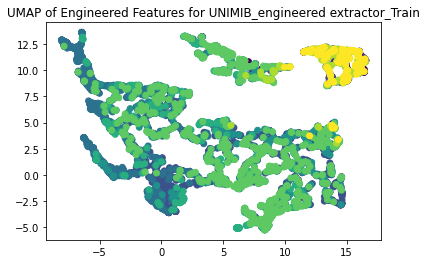

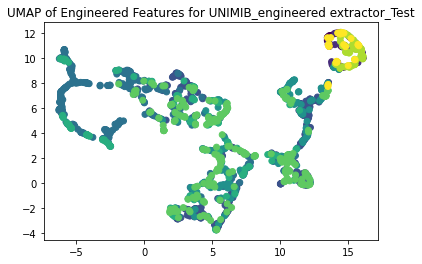

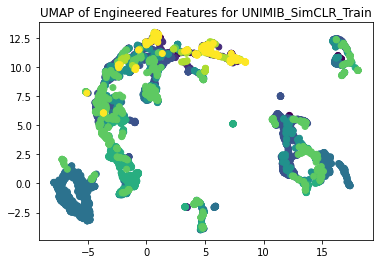

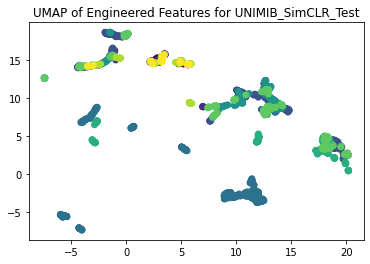

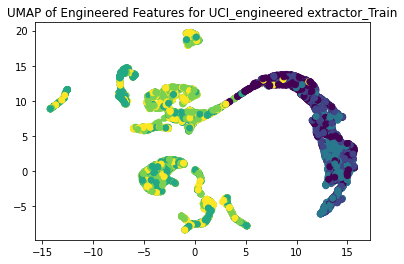

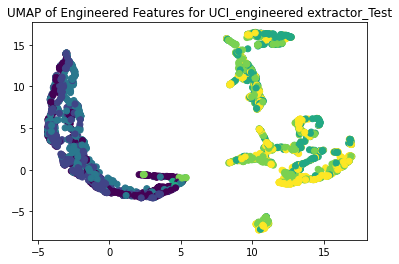

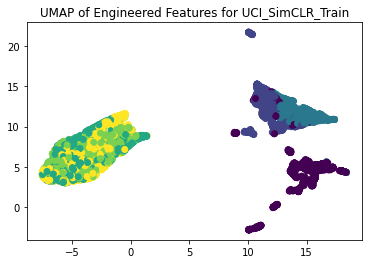

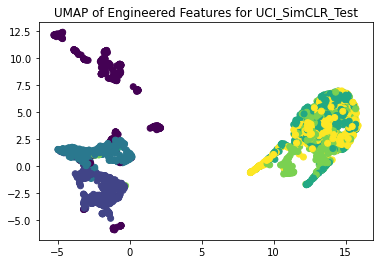

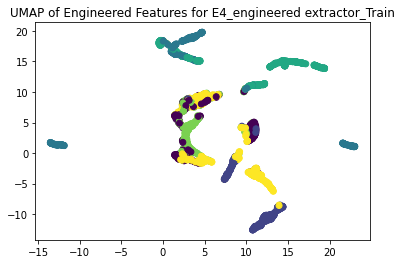

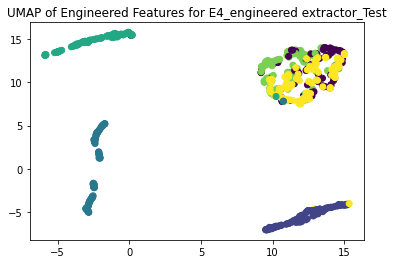

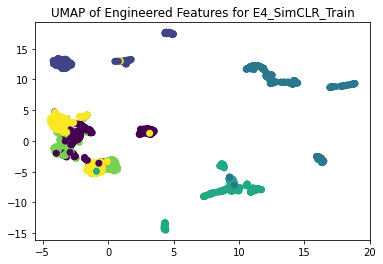

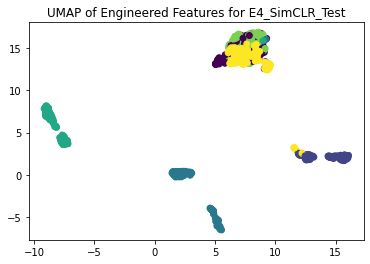

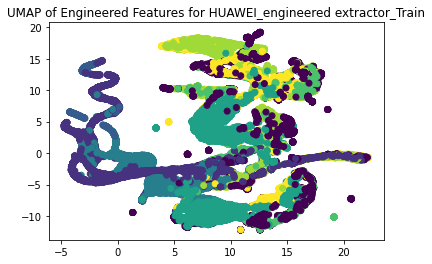

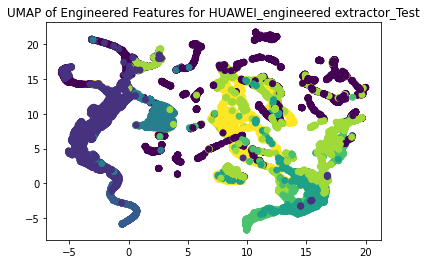

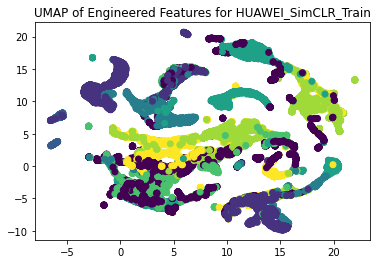

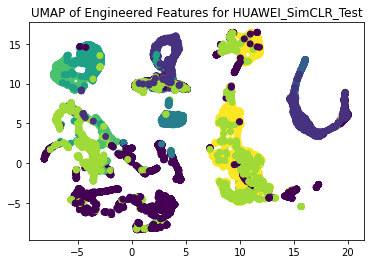

In [36]:
#ran into some issues with the UMAPS saving as images so im going to redeclare it here
#to try and fix it 
def produce_umap(features, y, n_c, name):
    if not (os.path.exists('UMAPS')):
        os.mkdir('UMAPS')
        os.chdir('UMAPS')
    else:
        os.chdir('UMAPS')
    reducer = umap.UMAP(n_neighbors = 15, n_components =n_c)
    embedding = reducer.fit_transform(features)
    plt.figure()
    plt.scatter(embedding[:,0], embedding[:,1], c=y)
    plt.title("UMAP of Engineered Features for "+ name)
    plt.savefig(name+".png")
    plt.show()
    os.chdir(home_dir)

#now that the produce_map function is fixed we can call it on all trained features
#UNIMIB
produce_umap(features_1_train_uni, y_train_uni, 2, "UNIMIB_engineered extractor_Train")
produce_umap(features_1_test_uni, y_test_uni, 2, "UNIMIB_engineered extractor_Test")
produce_umap(features_2_train_uni, y_train_uni, 2, "UNIMIB_SimCLR_Train")
produce_umap(features_2_test_uni, y_test_uni, 2, "UNIMIB_SimCLR_Test")

#UCI
produce_umap(features_1_train_uci, y_train_uci, 2, "UCI_engineered extractor_Train")
produce_umap(features_1_test_uci, y_test_uci, 2, "UCI_engineered extractor_Test")
produce_umap(features_2_train_uci, y_train_uci, 2, "UCI_SimCLR_Train")
produce_umap(features_2_test_uci, y_test_uci, 2, "UCI_SimCLR_Test")

#E4
produce_umap(features_1_train_e4, y_train_e4, 2, "E4_engineered extractor_Train")
produce_umap(features_1_test_e4, y_test_e4, 2, "E4_engineered extractor_Test")
produce_umap(features_2_train_e4, y_train_e4, 2, "E4_SimCLR_Train")
produce_umap(features_2_test_e4, y_test_e4, 2, "E4_SimCLR_Test")

#HUAWEI
produce_umap(features_1_train_hua, y_train_hua, 2, "HUAWEI_engineered extractor_Train")
produce_umap(features_1_test_hua, y_test_hua, 2, "HUAWEI_engineered extractor_Test")
produce_umap(features_2_train_hua, y_train_hua, 2, "HUAWEI_SimCLR_Train")
produce_umap(features_2_test_hua, y_test_hua, 2, "HUAWEI_SimCLR_Test")

In [27]:
#Clean up after ourselves
#need to add more clean up because of UCI dataset
import shutil

if os.path.exists('temp/'):
    shutil.rmtree('temp/')
if os.path.exists('UniMiB-SHAR/'):
    shutil.rmtree('UniMiB-SHAR/')